# Simple Trend-Following strategy

## Background

Applying a Simple Tren-Following strategy, where trades are made based on the direction of recent price movements. In this specific case, the strategy is based on the percentage change in the OHLC (open, high, low, close) prices, with a buy signal generated if the percentage change is positive and a sell signal generated if the percentage change is negative.

---

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../functions_library')

from functions import ROC, model_selection, Backtesting

seed = 42

### Read the CSV file into Pandas DataFrame

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
trading_df = pd.read_csv(
    Path("../Resources/ETHUSDT-1h-data.csv"), 
    index_col="timestamp", 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
trading_df.head()

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.0,301.61,125.66877,1502945999999,37684.804181,129,80.56377,24193.440789,0
2017-08-17 05:00:00,301.61,303.28,300.0,303.10,377.67246,1502949599999,114043.282676,202,328.10428,99079.803569,0
2017-08-17 06:00:00,302.40,304.44,301.9,302.68,303.86672,1502953199999,92034.441294,182,259.28668,78525.948613,0
2017-08-17 07:00:00,302.68,307.96,302.6,307.96,754.74510,1502956799999,229725.136967,198,592.43176,180297.966961,0
2017-08-17 08:00:00,307.95,309.97,307.0,308.62,150.75029,1502960399999,46559.462371,182,140.68470,43451.495398,0


### Add a daily return values column to the DataFrame

In [3]:
# Calculate the daily returns using the closing prices and the pct_change function
trading_df["actual_returns"] = trading_df["close"].pct_change()

# Drop all NaN values from the DataFrame
trading_df = trading_df.dropna()

# Review the DataFrame
display(trading_df.head())
display(trading_df.tail())

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,actual_returns
timestamp,,,,,,,,,,,,
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246,1502949599999,114043.282676,202,328.10428,99079.803569,0,0.004940
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672,1502953199999,92034.441294,182,259.28668,78525.948613,0,-0.001386
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510,1502956799999,229725.136967,198,592.43176,180297.966961,0,0.017444
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029,1502960399999,46559.462371,182,140.68470,43451.495398,0,0.002143
2017-08-17 09:00:00,308.62,312.00,308.62,310.00,469.27879,1502963999999,145510.063225,198,438.71878,136034.157708,0,0.004472


,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,actual_returns
timestamp,,,,,,,,,,,,
2023-01-23 18:00:00,1629.03,1640.49,1626.06,1628.85,26815.5440,1674500399999,4.378866e+07,34634,13907.3933,2.270701e+07,0,-0.000104
2023-01-23 19:00:00,1628.85,1630.57,1610.04,1619.88,27357.8436,1674503999999,4.432545e+07,35086,12780.9097,2.070848e+07,0,-0.005507
2023-01-23 20:00:00,1619.89,1635.26,1618.65,1634.80,13128.4739,1674507599999,2.133510e+07,21144,6794.6870,1.104395e+07,0,0.009211
2023-01-23 21:00:00,1634.80,1635.50,1629.53,1631.84,9298.6748,1674511199999,1.518002e+07,15686,4916.0862,8.025556e+06,0,-0.001811
2023-01-23 22:00:00,1631.84,1635.75,1630.90,1632.64,5790.1341,1674514799999,9.458013e+06,7167,3912.6361,6.391575e+06,0,0.000490


#### Create the features set

# Part 2 - Adding more Features, defining test and training dataset, and more models

In [4]:
import finta as ft
from finta import TA
import talib

ohlcv_df = trading_df

# List of time periods to use for Moving Averages calculation
timeperiods = [5,7,14,20,30,50,70,100,150,200]

df = ohlcv_df.copy()

# Calculate SMAs and add them to the DataFrame
for t in timeperiods:
    #tsma = TA.SMA(df, t).shift(1)
    sma = TA.SMA(df, t)
    ema = TA.EMA(df, t)
    atr = TA.ATR(df, t)  #Average True Range
    adx = TA.ADX(df, t) 
    rsi = TA.RSI(df, t)
    hma = TA.HMA(df, t)
    vama = TA.VAMA(df, t)
 
    # calculate the Force Index
    #force_index = pd.Series(df['close'].diff(1) * df['volume'], index=df.index)
    #force_ema = force_index.ewm(span=t, min_periods=0, adjust=True, ignore_na=False).mean()    
    
    #df['force_index'] = force_index
    #df[f'force_index_ema_{t}'] = force_ema # add the Force Index and its EMA to the DataFrame
    #df[f'TSMA_{t}'] = tsma
    df[f'SMA_{t}'] = sma
    df[f'EMA_{t}'] = ema
    df[f'HMA_{t}'] = hma
    df[f'VAMA_{t}'] = vama
    df[f'ATR_{t}'] = atr
    df[f'ADX_{t}'] = adx
    df[f'RSI_{t}'] = rsi
    
    
# Calculate the Parabolic SAR
#sar = TA.PSAR(df)

# Add the SAR values and trend direction to the DataFrame
#df['sar'] = sar['psar']
#df['psarbear'] = sar['psarbear']
#df['psarbull'] = sar['psarbull']

df['UO'] = TA.UO(df)

# Adding Awesome Indicator (AO)
df['AO'] = TA.AO(df)
df['OBV'] =TA.OBV(df)

# Adding Chaikin Indicator 
df['CHAIKIN'] = TA.CHAIKIN(df)

# Adding Bollinger Bands
df[['BB_UPPER','BB_MED','BB_LOWER']] =TA.BBANDS(df)

# Calculate the Keltner Channel with TALIB
#df[['KC_UPPER','KC_MED','KC_LOWER']] = TA.KC(df)

# calculate Commodity Channel Index (CCI)
df['cci'] = TA.CCI(df)

# assuming you have OHLCV data in a pandas dataframe called "df"
#volume_momentum = talib.MOM(df['volume'])

In [5]:
'''
# calculate the Ichimoku Kinko Hyo indicator
# Calculate the conversion line
nine_period_high = df['high'].rolling(window=9).max()
nine_period_low = df['low'].rolling(window=9).min()
df['tenkan_sen'] = (nine_period_high + nine_period_low) / 2

# Calculate the base line
periods = 26
twenty_six_period_high = df['high'].rolling(window=periods).max()
twenty_six_period_low = df['low'].rolling(window=periods).min()
df['kijun_sen'] = (twenty_six_period_high + twenty_six_period_low) / 2

# Calculate the leading span A
df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(periods=periods)

# Calculate the leading span B
periods2 = 52
fifty_two_period_high = df['high'].rolling(window=periods2).max()
fifty_two_period_low = df['low'].rolling(window=periods2).min()
df['senkou_span_b'] = ((fifty_two_period_high + fifty_two_period_low) / 2).shift(periods=periods)

# Calculate the lagging span
df['chikou_span'] = df['close'].shift(periods=-periods)

df = df.drop(["ignore"], axis =1)
'''

'\n# calculate the Ichimoku Kinko Hyo indicator\n# Calculate the conversion line\nnine_period_high = df[\'high\'].rolling(window=9).max()\nnine_period_low = df[\'low\'].rolling(window=9).min()\ndf[\'tenkan_sen\'] = (nine_period_high + nine_period_low) / 2\n\n# Calculate the base line\nperiods = 26\ntwenty_six_period_high = df[\'high\'].rolling(window=periods).max()\ntwenty_six_period_low = df[\'low\'].rolling(window=periods).min()\ndf[\'kijun_sen\'] = (twenty_six_period_high + twenty_six_period_low) / 2\n\n# Calculate the leading span A\ndf[\'senkou_span_a\'] = ((df[\'tenkan_sen\'] + df[\'kijun_sen\']) / 2).shift(periods=periods)\n\n# Calculate the leading span B\nperiods2 = 52\nfifty_two_period_high = df[\'high\'].rolling(window=periods2).max()\nfifty_two_period_low = df[\'low\'].rolling(window=periods2).min()\ndf[\'senkou_span_b\'] = ((fifty_two_period_high + fifty_two_period_low) / 2).shift(periods=periods)\n\n# Calculate the lagging span\ndf[\'chikou_span\'] = df[\'close\'].shift(p

### Add a daily return values column to the DataFrame

In [6]:
# Calculate the daily returns using the closing prices and the pct_change function
df["actual_returns"] = df["close"].pct_change()

# Drop all NaN values from the DataFrame
df = df.dropna()

# Review the DataFrame
df.head()

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,...,ADX_200,RSI_200,UO,AO,OBV,CHAIKIN,BB_UPPER,BB_MED,BB_LOWER,cci
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-02 19:00:00,340.23,341.47,334.93,336.18,234.99340,1504382399999,79526.968574,231,86.69621,29414.424900,...,21.570237,49.329234,43.213110,-33.588265,3222.41904,-137.517059,393.172933,357.5685,321.964067,-102.539757
2017-09-02 20:00:00,338.08,338.47,325.63,325.63,452.29677,1504385999999,149380.241385,662,90.08272,30025.432171,...,21.549612,48.311234,37.380635,-32.722971,2770.12227,-282.506411,388.022171,354.1340,320.245829,-133.249723
2017-09-02 21:00:00,327.16,331.08,320.08,324.00,236.00212,1504389599999,76605.814118,225,92.34362,29929.388672,...,21.542214,48.156917,41.696457,-32.974676,2534.12015,-337.709600,384.387306,351.1105,317.833694,-139.374949
2017-09-02 22:00:00,325.45,340.10,325.45,329.72,229.42859,1504393199999,76538.381494,241,41.72442,14008.664330,...,21.504710,48.734450,36.172775,-32.457912,2763.54874,-360.037586,379.516187,348.4625,317.408813,-93.896395
2017-09-02 23:00:00,331.77,343.15,329.72,343.14,280.21839,1504396799999,94090.992031,326,33.91274,11422.176426,...,21.457880,50.046603,43.012434,-31.865235,3043.76713,-247.413454,374.386794,346.6935,319.000206,-50.887796


In [7]:
# Create a new column in the trading_df called signal setting its value to zero.
df["signal"] = 0.0

# Create the signal to buy
df.loc[(df["actual_returns"] >= 0), "signal"] = 1

# Create the signal to sell
df.loc[(df["actual_returns"] < 0), "signal"] = -1

In [8]:
df["signal"].value_counts()

 1.0    23789
-1.0    23220
Name: signal, dtype: int64

---
### Dealing with Class Imbalance using Undersampling 

In [9]:
import pandas as pd
from sklearn.utils import resample

# Count the number of samples in each class
class_counts = df['signal'].value_counts()

# Find the class with fewer samples
minority_class = class_counts.idxmin()

# Split the dataframe into the majority and minority classes
majority_class = df[df['signal'] != minority_class]
minority_class = df[df['signal'] == minority_class]

# Undersample the majority class to match the number of samples in the minority class
undersampled_majority = resample(majority_class,
                                 replace=False,
                                 n_samples=len(minority_class),
                                 random_state=42)

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([undersampled_majority, minority_class])

# Shuffle the rows in the balanced dataframe
balanced_df = balanced_df.sample(frac=1, random_state=42)

In [10]:
balanced_df = df

In [11]:
balanced_df["signal"].value_counts()

 1.0    23789
-1.0    23220
Name: signal, dtype: int64

---

### Generating the Feauture and Target Sets

In [12]:
# Create a new column in the trading_df called signal setting its value to zero.
X= balanced_df.copy()
X= X.drop(["open","high","low","close","volume","actual_returns"], axis =1).shift().dropna().copy()

#### Creating the feature set

In [13]:
X.head()

,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,SMA_5,EMA_5,HMA_5,VAMA_5,...,RSI_200,UO,AO,OBV,CHAIKIN,BB_UPPER,BB_MED,BB_LOWER,cci,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-02 20:00:00,1.504382e+12,79526.968574,231.0,86.69621,29414.424900,0.0,339.158,339.736879,337.449778,339.376015,...,49.329234,43.213110,-33.588265,3222.41904,-137.517059,393.172933,357.5685,321.964067,-102.539757,-1.0
2017-09-02 21:00:00,1.504386e+12,149380.241385,662.0,90.08272,30025.432171,0.0,335.940,335.034586,328.105556,334.957058,...,48.311234,37.380635,-32.722971,2770.12227,-282.506411,388.022171,354.1340,320.245829,-133.249723,-1.0
2017-09-02 22:00:00,1.504390e+12,76605.814118,225.0,92.34362,29929.388672,0.0,333.346,331.356391,320.744222,332.311002,...,48.156917,41.696457,-32.974676,2534.12015,-337.709600,384.387306,351.1105,317.833694,-139.374949,-1.0
2017-09-02 23:00:00,1.504393e+12,76538.381494,241.0,41.72442,14008.664330,0.0,330.964,330.810927,324.167778,329.932132,...,48.734450,36.172775,-32.457912,2763.54874,-360.037586,379.516187,348.4625,317.408813,-93.896395,1.0
2017-09-03 00:00:00,1.504397e+12,94090.992031,326.0,33.91274,11422.176426,0.0,331.734,334.920618,338.516000,331.607894,...,50.046603,43.012434,-31.865235,3043.76713,-247.413454,374.386794,346.6935,319.000206,-50.887796,1.0


#### Creating the target set 

In [14]:
# Copy the new signal column to a new Series called y.
y = balanced_df["signal"][1:].copy()

# keeping y and X the same size 
y = y[X.index]

In [15]:
X.shape

(47008, 85)

In [16]:
y.shape

(47008,)

In [17]:
y.value_counts()

 1.0    23789
-1.0    23219
Name: signal, dtype: int64

#### Splitting the data and building the testing and training set using a timeframe

In [18]:
# Imports 
from pandas.tseries.offsets import DateOffset

# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
#print(training_begin)

# Select the ending period for the training data with an offset of 36 months
training_end = X.index.min() + DateOffset(months=24)

# Display the training end date
#print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
display(X_train.head())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
display(X_test.head())

,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,SMA_5,EMA_5,HMA_5,VAMA_5,...,RSI_200,UO,AO,OBV,CHAIKIN,BB_UPPER,BB_MED,BB_LOWER,cci,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-02 20:00:00,1.504382e+12,79526.968574,231.0,86.69621,29414.424900,0.0,339.158,339.736879,337.449778,339.376015,...,49.329234,43.213110,-33.588265,3222.41904,-137.517059,393.172933,357.5685,321.964067,-102.539757,-1.0
2017-09-02 21:00:00,1.504386e+12,149380.241385,662.0,90.08272,30025.432171,0.0,335.940,335.034586,328.105556,334.957058,...,48.311234,37.380635,-32.722971,2770.12227,-282.506411,388.022171,354.1340,320.245829,-133.249723,-1.0
2017-09-02 22:00:00,1.504390e+12,76605.814118,225.0,92.34362,29929.388672,0.0,333.346,331.356391,320.744222,332.311002,...,48.156917,41.696457,-32.974676,2534.12015,-337.709600,384.387306,351.1105,317.833694,-139.374949,-1.0
2017-09-02 23:00:00,1.504393e+12,76538.381494,241.0,41.72442,14008.664330,0.0,330.964,330.810927,324.167778,329.932132,...,48.734450,36.172775,-32.457912,2763.54874,-360.037586,379.516187,348.4625,317.408813,-93.896395,1.0
2017-09-03 00:00:00,1.504397e+12,94090.992031,326.0,33.91274,11422.176426,0.0,331.734,334.920618,338.516000,331.607894,...,50.046603,43.012434,-31.865235,3043.76713,-247.413454,374.386794,346.6935,319.000206,-50.887796,1.0


,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,SMA_5,EMA_5,HMA_5,VAMA_5,...,RSI_200,UO,AO,OBV,CHAIKIN,BB_UPPER,BB_MED,BB_LOWER,cci,signal
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-02 20:00:00,1.567454e+12,1.664446e+06,4917.0,4881.51640,8.661784e+05,0.0,175.510,175.976082,178.740889,175.720433,...,48.156612,55.169906,4.053647,-2.858292e+06,4193.856671,176.949064,172.2620,167.574936,208.994526,1.0
2019-09-02 21:00:00,1.567458e+12,5.504732e+06,10129.0,16822.14102,3.019287e+06,0.0,176.874,177.087388,179.384667,176.946654,...,48.698839,53.622306,5.098147,-2.827619e+06,3788.203158,178.270551,172.6955,167.120449,211.173385,1.0
2019-09-02 22:00:00,1.567462e+12,2.138998e+06,5356.0,5888.47328,1.055605e+06,0.0,178.014,177.658259,179.621111,177.801861,...,48.542076,51.187745,6.047882,-2.839551e+06,1667.199315,179.211664,173.1065,167.001336,163.452207,-1.0
2019-09-02 23:00:00,1.567465e+12,2.119756e+06,4889.0,6123.53128,1.093531e+06,0.0,178.184,177.705506,178.481333,178.309808,...,48.236087,48.798055,6.338971,-2.851421e+06,-2769.099904,179.807404,173.4500,167.092596,117.196774,-1.0
2019-09-03 00:00:00,1.567469e+12,1.508405e+06,4831.0,3866.87644,6.874953e+05,0.0,178.322,177.820337,177.754889,178.507278,...,48.317941,51.089420,6.039176,-2.842937e+06,-2289.936050,180.352326,173.8180,167.283674,90.603931,1.0


#### Standardizing the Data

In [19]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---
### Remove highly-correlated features

In [20]:
'''
# calculate the correlation matrix
corr_matrix = X.corr().abs()

# get the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# get the index of the features with the lowest correlation
to_keep = [column for column in upper.columns if any(upper[column] < 0.9)]

# keep only the features with the lowest correlation
X = X[to_keep]
'''

'\n# calculate the correlation matrix\ncorr_matrix = X.corr().abs()\n\n# get the upper triangle of the correlation matrix\nupper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))\n\n# get the index of the features with the lowest correlation\nto_keep = [column for column in upper.columns if any(upper[column] < 0.9)]\n\n# keep only the features with the lowest correlation\nX = X[to_keep]\n'

--- 
Use RFE to keep the best features

In [21]:
# imports
#import sklearn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
import sklearn.ensemble

# Classification Metrics 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc #plot_roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# ML models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb

# libraries for Shapely analysis
import shap 

In [22]:
# Create a logistic regression model
model = LogisticRegression()

# Create an RFE model to select the best features
rfe = RFE(model, n_features_to_select=15)

# Fit the RFE model to the data
rfe = rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[rfe.support_]


# keep only specified columns in the dataframe
#X = X.iloc[:, selected_features]
X = X[selected_features]


# Print the selected features
print ("Number of selected features:", len(X.columns), "\nSelected features:\n",selected_features)

Number of selected features: 15 
Selected features:
 Index(['close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av',
       'HMA_5', 'RSI_5', 'HMA_7', 'RSI_7', 'SMA_200', 'EMA_200', 'VAMA_200',
       'OBV', 'CHAIKIN', 'cci'],
      dtype='object')


---
Choose the best model 

In [23]:
#results_df = model_selection(X_test_scaled, y_test)

In [24]:
#results_df

---

### Incorporate the xgboost Machine Learning Into the Trading Strategy

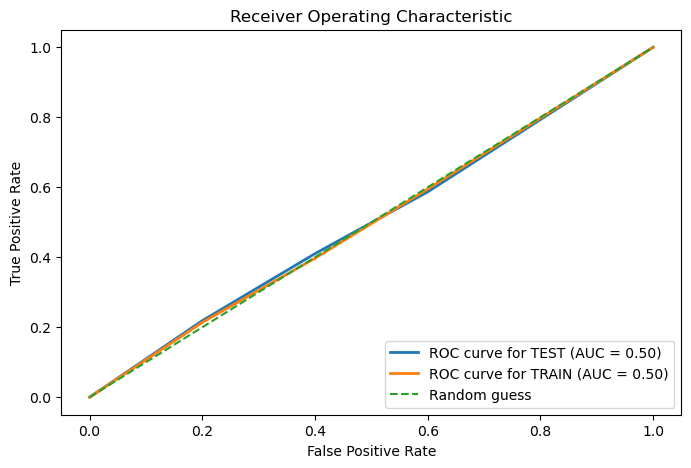

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       0.49      1.00      0.66      8588
         1.0       0.54      0.00      0.00      8774

    accuracy                           0.49     17362
   macro avg       0.52      0.50      0.33     17362
weighted avg       0.52      0.49      0.33     17362


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       0.49      1.00      0.66     14631
         1.0       0.59      0.00      0.00     15016

    accuracy                           0.49     29647
   macro avg       0.54      0.50      0.33     29647
weighted avg       0.54      0.49      0.33     29647

Test accuracy: 0.49
>> Test precision: 0.59 <<
Test recall: 0.00
Test F1 score: 0.49
Test AUC score: 0.50


In [25]:
import xgboost as xgb
#from xgboost import xgbClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

#replace -1 by 0 as xgboost expects a boolean target vector (only 0 and 1)
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0)

# Create a xgb Classifier model
xgb_clf = xgb.XGBClassifier(reg_alpha=15)

xgb_clf.fit(X_train_scaled, y_train) 

# Use the best model to make predictions on the test data
y_pred_xgb = xgb_clf.predict(X_test_scaled)

ROC(xgb_clf,X_train,X_test,y_train,y_test)

### Displaying ROC Curve

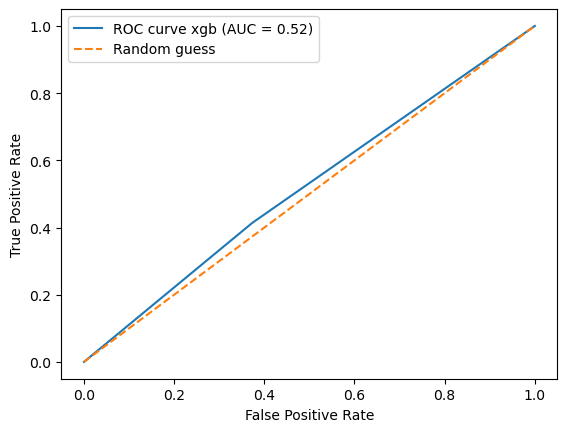

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

xgb_signal_predictions = xgb_clf.predict(X_test_scaled)

#Calculate ROC Curve
xgb_fpr, xgb_tpr, pca_thresholds = roc_curve(y_test, xgb_signal_predictions )

# Calculate the AUC 
xgb_auc = roc_auc_score(y_test, xgb_signal_predictions )

# Plot the ROC curve
plt.plot(xgb_fpr, xgb_tpr, label='ROC curve xgb (AUC = {:.2f})'.format(xgb_auc))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

<Axes: xlabel='timestamp'>

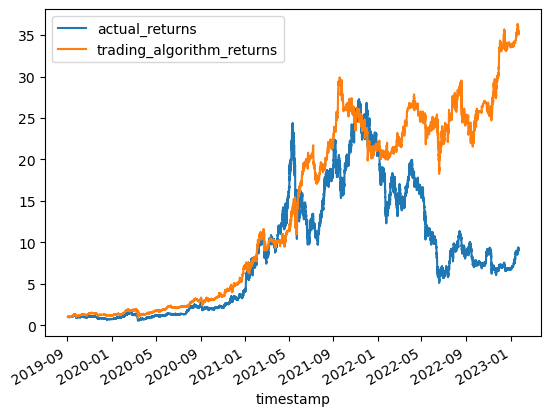

In [27]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = xgb_clf

# Backtest using our exteranl function
xgb_predictions_df = Backtesting (df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + xgb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [28]:
'''
# Create the classifier model
from sklearn.svm import NuSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create NuSVC classifier
svm_model = NuSVC(nu=0.5, probability= True, kernel='rbf')

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

ROC(svm_model,X_train_scaled, X_test_scaled, y_train, y_test)
'''

"\n# Create the classifier model\nfrom sklearn.svm import NuSVC, SVC\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\n# Create NuSVC classifier\nsvm_model = NuSVC(nu=0.5, probability= True, kernel='rbf')\n\n# Fit the model to the data using X_train_scaled and y_train\nsvm_model = svm_model.fit(X_train_scaled, y_train)\n\nROC(svm_model,X_train_scaled, X_test_scaled, y_train, y_test)\n"

Permutation explainer: 29648it [36:24, 13.44it/s]                                                                                                                                                     


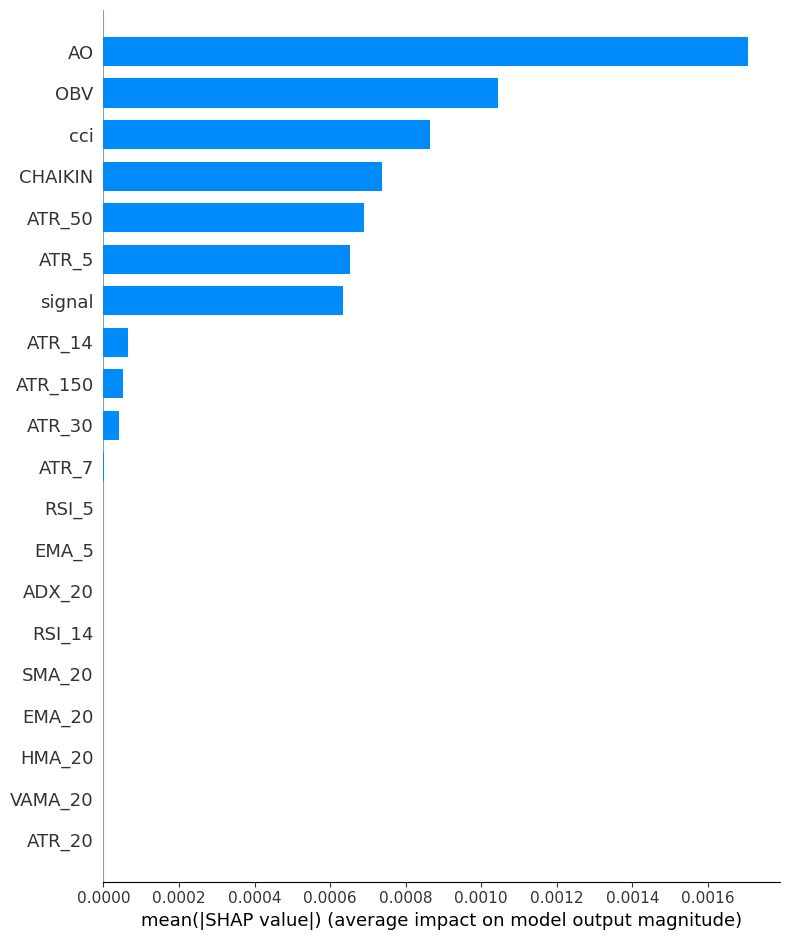

In [31]:
# define which classifier to use 
clf = xgb_clf

# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, X_test)

# Calculate SHAP values
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

---
## Adding CatBoost

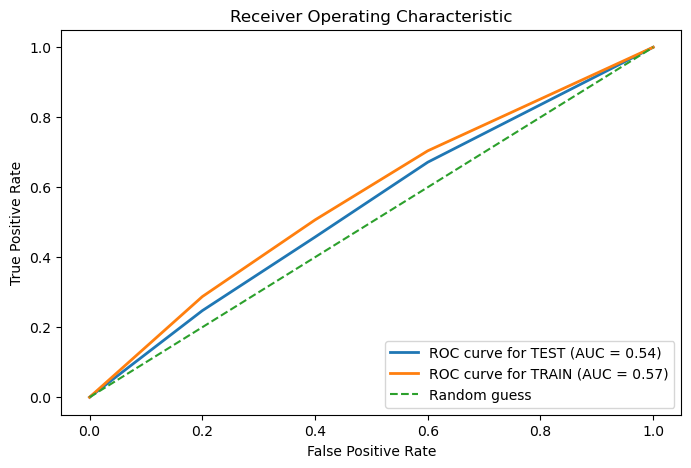

TRAINING classification report: 
               precision    recall  f1-score   support

         0.0       0.56      0.49      0.52      8588
         1.0       0.55      0.62      0.58      8774

    accuracy                           0.55     17362
   macro avg       0.55      0.55      0.55     17362
weighted avg       0.55      0.55      0.55     17362


TESTING classification report: 
               precision    recall  f1-score   support

         0.0       0.54      0.45      0.49     14631
         1.0       0.54      0.62      0.58     15016

    accuracy                           0.54     29647
   macro avg       0.54      0.54      0.53     29647
weighted avg       0.54      0.54      0.54     29647

Test accuracy: 0.54
>> Test precision: 0.54 <<
Test recall: 0.62
Test F1 score: 0.54
Test AUC score: 0.54


In [29]:
# Import libraries
from catboost import CatBoostClassifier
# Initialize the CatBoost model

cb_clf = CatBoostClassifier(iterations=250,random_state=seed  ,l2_leaf_reg=10000, verbose = False)

# Train the model on the training data
cb_clf.fit(X_train_scaled, y_train)

ROC(cb_clf,X_train_scaled, X_test_scaled, y_train, y_test)


<Axes: xlabel='timestamp'>

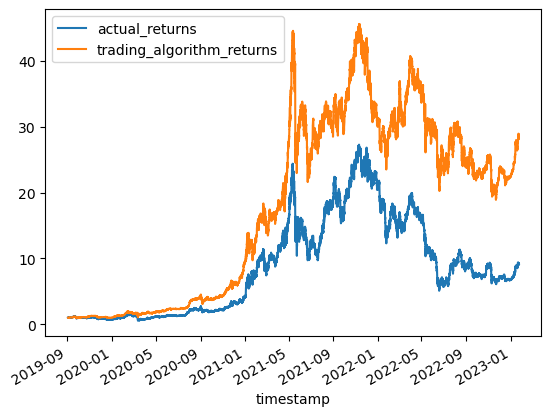

In [30]:
# Define the trading fee as a decimal
trading_fee = 0.00075
classifier = cb_clf

# Backtest using our exteranl function
cb_predictions_df = Backtesting (df, X_test, X_test_scaled, classifier,trading_fee)

# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + cb_predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
# SHAP Analysis 
# define which classifier to use 
clf = cb_clf

# Initialize SHAP explainer
explainer = shap.Explainer(clf.predict, X_test)

# Calculate SHAP values
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

Permutation explainer:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 23109/29647 [31:17<03:21, 32.39it/s]

In [ ]:
'''
# Create the classifier model
from sklearn.svm import NuSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create NuSVC classifier
svm_model = NuSVC(nu=0.5, probability= True, kernel='rbf')

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

ROC(svm_model,X_train_scaled, X_test_scaled, y_train, y_test)
'''
